In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import os
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
df=pd.read_csv("https://raw.githubusercontent.com/Himanshu-1703/reddit-sentiment-analysis/refs/heads/main/data/reddit.csv")
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
df.isnull().sum()

,0
clean_comment,100
category,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df=df[~(df['clean_comment']==' ')]

# Preprocessor Function
* remove ulrs
* remove unecessary stopwords
* remove `\n and \t`
* Apply lemitization



In [ ]:
def preprocess(text):
  """
  This fun is responsible for apply all the preprocessing steps.
  """
  try:
    # convert the text into lower case and also remove the unecessary spaces
    text=text.lower().strip()

    # remove the urls
    text=re.sub(r'http[s]?://\S+|www\.\S+','',text)

    # Remove the \n and \t with ""
    text=text.replace("\n"," ").replace("\t"," ")

    # Now get the only

    # Remove the unecessry stopwords
    stopword=set(stopwords.words('english')) - set(["not","but",'because','not','never','no',"about"])

    tokens=[word for word in text.split() if word not in stopword]

    # Apply lemitization
    lemmatizer=WordNetLemmatizer()
    final_token=[lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(final_token)
  except Exception as e:
    return str(e)

# Test the function

In [ ]:
preprocess(df['clean_comment'][0].upper()+"https://github.com/Sami606713/youtube_comment_analysis/tree/main"+"\n\n\t\t\t")

'family mormon never tried explain still stare puzzled time time like kind strange creature nonetheless come admire patience calmness equanimity acceptance compassion developed thing buddhism teach'

In [ ]:
df['clean_comment'][0].upper()+"https://github.com/Sami606713/youtube_comment_analysis/tree/main"+"\n\n\t\t\t"

' FAMILY MORMON HAVE NEVER TRIED EXPLAIN THEM THEY STILL STARE PUZZLED FROM TIME TIME LIKE SOME KIND STRANGE CREATURE NONETHELESS THEY HAVE COME ADMIRE FOR THE PATIENCE CALMNESS EQUANIMITY ACCEPTANCE AND COMPASSION HAVE DEVELOPED ALL THE THINGS BUDDHISM TEACHES https://github.com/Sami606713/youtube_comment_analysis/tree/main\n\n\t\t\t'

# Apply the function

In [ ]:
%%time
df["final_comments"]=df['clean_comment'].apply(preprocess)

CPU times: user 11.5 s, sys: 1.02 s, total: 12.6 s
Wall time: 19.3 s


# Now connect the colab to mlflow with dagshub

In [ ]:
!pip install mlflow dagshub

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.9/247.9 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.4 MB/s eta 0:00:00
   ━━━

In [ ]:
import mlflow
import dagshub
# connect to dagshub using dagshub token
dagshub_token="1052d14a61dff596b35e5ac72ec8bc5a57613415"
if dagshub_token:
    os.environ['MLFlow_TRACKING_USERNAME']=dagshub_token
    os.environ['MLFlow_TRACKING_PASSWORD']=dagshub_token
    # Set up the MLflow tracking URI with authentication using the token
    mlflow.set_tracking_uri(f'https://{dagshub_token}:@dagshub.com/Sami606713/youtube_comment_analysis.mlflow')

    print("DagsHub login successful!")
else:
    print("DagsHub token not found. Please set the DAGSHUB_TOKEN environment variable.")

DagsHub login successful!


# What we can log
- Train test split
- log the data
- convert the text into vector
- train the model
- log the model
- log the metrics

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
final_df=df[['final_comments','category']]
final_df.head()

,final_comments,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
# saperate feature and label
feature=final_df[['final_comments']]
target=final_df['category']

In [ ]:
feature.head(2)

,final_comments
0,family mormon never tried explain still stare ...
1,buddhism much lot compatible christianity espe...


In [ ]:
target.head(2)

,category
0,1
1,1


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(feature,target,test_size=0.2,random_state=42)

In [ ]:
x_train.shape , y_train.shape

((29439, 1), (29439,))

In [ ]:
# Build a pipeline for vectorize the data and train the model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
# Build a transformer
transformer=ColumnTransformer(transformers=[
    ("Encode",TfidfVectorizer(ngram_range=(2, 2)),'final_comments')
]
,remainder="passthrough")
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Encode', TfidfVectorizer(ngram_range=(2, 2)),
                                 'final_comments')])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
# Build a final pipeline
final=Pipeline(steps=[
    ("transformers",transformer),
    ("Model",LogisticRegression())
])
final

Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encode',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               2)),
                                                  'final_comments')])),
                ('Model', LogisticRegression())])

In [ ]:
final.fit(x_train,y_train)

Pipeline(steps=[('transformers',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encode',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               2)),
                                                  'final_comments')])),
                ('Model', LogisticRegression())])

In [ ]:
y_pred=final.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{confusion_mat}")


Accuracy: 0.5927989130434783
Precision: 0.6303367758721385
Recall: 0.5927989130434783
Confusion Matrix:
[[ 179  389 1083]
 [  16 1610  883]
 [  39  587 2574]]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.76      0.11      0.19      1651
           0       0.62      0.64      0.63      2509
           1       0.57      0.80      0.67      3200

    accuracy                           0.59      7360
   macro avg       0.65      0.52      0.50      7360
weighted avg       0.63      0.59      0.55      7360



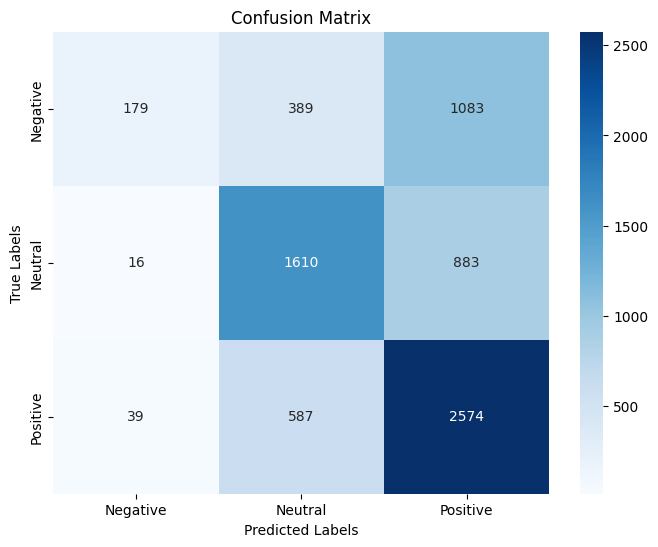

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# 0   1    2

# negative   neutral   positive

# Log all the things using mlflow

In [ ]:
import io
from matplotlib.figure import Figure
import mlflow.sklearn

In [ ]:
# Set experiment name
mlflow.set_experiment("Base Model Experiment")
# Now you can use MLflow to log parameters, metrics, and artifacts
with mlflow.start_run(run_name="RandomForest-Bigram"):
  # split the data into train and test set
  x_train,x_test,y_train,y_test=train_test_split(feature,target,test_size=0.2,random_state=42)


  # Add the transformer
  final=Pipeline(steps=[
    ("transformers",transformer),
    ("Model",RandomForestClassifier())
  ])

  # Fit the pipeline
  final.fit(x_train,y_train)

  # Generate the prediction
  y_pred=final.predict(x_test)

  # Calculate the accuracy precession recall confussion matrix
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  confusion_mat = confusion_matrix(y_test, y_pred)

  # Log all the things on mlflow and also log the model with parameters
  mlflow.log_metric("Accuracy",accuracy)
  mlflow.log_metric("Precession",precision)
  mlflow.log_metric("recall",recall)

  # Log the model
  model=final.named_steps['Model']
  mlflow.sklearn.log_model(model, "Model")

  # log the parameter
  mlflow.log_params(model.get_params())

  # Log the confussion matrix plot
  fig = Figure(figsize=(8, 6))
  ax = fig.subplots()
  sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Negative', 'Neutral', 'Positive'],
              yticklabels=['Negative', 'Neutral', 'Positive'], ax=ax)
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix')

  # Save the plot to a BytesIO object
  buf = io.BytesIO()
  plt.savefig("confusion_matrix.png")
  plt.close()
  # Log the plot as an artifact
  mlflow.log_artifact("confusion_matrix.png")

  # Log the data
  df.to_csv("reddit.csv",index=False)
  mlflow.log_artifact("reddit.csv")

2024/10/11 05:32:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/11 05:32:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest-Bigram at: https://1052d14a61dff596b35e5ac72ec8bc5a57613415:@dagshub.com/Sami606713/youtube_comment_analysis.mlflow/#/experiments/0/runs/3a5eea5bec0844bb8e8b08018b46c092.
2024/10/11 05:32:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://1052d14a61dff596b35e5ac72ec8bc5a57613415:@dagshub.com/Sami606713/youtube_comment_analysis.mlflow/#/experiments/0.


#Hyperparameter tunning